## Single-Sensor, Multiple-Time Independent Component Analysis (ICA) for Moving Sources (Synthetic Dataset: Phase-Synchronized)

### Authors
* Kevin Chu (kevin@velexi.com)

### Executive Summary

In this Jupyter notebook, we investigate the use of the ICA algorithm when a single sensor is used for measurements. For a system based on a single stationary sensor, independent signal recordings (a requirement for ICA) can be acquired if we can assume that the sources are _moving relative to the sensor_.

#### Key Results

* For synthetic data _without random phase shifts between recording times_ (i.e., synchronized in phase between recording times), single-sensor, multiple-time ICA can effectively extract source signals that are identifiable by their power spectra.

### Methods

* ICA is performed over a short duration that balances the competing goals of using a time window that is (1) long enough to capture structure of the underlying source signals and (2) short enough that the distances from the sources to the sensor do not change significantly.

* The performance of ICA is evaluated by visually comparing the power spectra of extracted and pure source signals.

### Dataset

For this demonstration, we use a synthetic dataset constructed by combining audio clips for pure sources in the following manner. For additional details, See the help message for `generate-synthetic-dataset.py`.

* We randomly select initial positions (relative to the sensor) for all of the sources. The distances of the pure sources from the sensor are known; the azimuths are randomly selected.

* The heading and velocity of each source is randomly selected.

* At multiple points in time that allow for the sources to travel far enough change the strength of their signals at the sensor, we estimate the signal strength for each source and combine the pure source signals with the scaling implied by the solution of the pressure wave equation.

* For the sensor signal recorded at each time point, _no random "temporal shifts" are applied to source signals_. That is, the source signals remain phase-synchronized across all recordings.

### Notes

* This notebook is designed to be run with any synthetic dataset located at the user-specified path.

* For the figures that appear in the version of the notebook committed to the Git repository, the following source signals were used to construct the analyzed synthetic signals:

  - pibuoy-v2-mk2-3-1663785032-hydrophone-404000-944000-368242220-ClassB-UnderWayUsingEngine-248.7.wav
  - pibuoy-v2-mk2-3-1664207665-hydrophone-303000-843000-563089900-Tanker-UnderWayUsingEngine-490.0.wav
  - pibuoy-v2-mk2-3-1664859004-hydrophone-275000-815000-477224800-Cargo-UnderWayUsingEngine-499.1.wav

### History

#### 2023-03-20

- Add notes about dataset used to generate figures.

#### 2023-03-04

- Polish notebook.

#### 2023-03-01

- Finish notebook write-up.

#### 2023-02-23

- Initial revision.

### User Parameters

#### Data parameters
* `data_dir`: directory containing audio clips generated with no temporal shifts of sources between time points
* `source_dir`: directory containing audio clips of pure sources

#### ICA parameters
* `num_active_sources`: number of active sources to attempt to extract from audio clips
* `duration`: duration of audio clip to use for analysis

#### Signal processing parameters
* `passband`: passband edge frequencies (Hz)
* `stopband`: stopband edge frequencies (Hz)
* `gpass`: maximum loss in the passband (dB)
* `gstop`: minimum attenuation in the stopband (dB)

In [1]:
# --- User parameters

import os

# Data parameters
data_dir = os.path.join("..", "data", "synthetic-single-sensor-multiple-time-no-temporal-shift")
sources_dir = os.path.join("..", "data", "pibuoy-single-source-clips")

# ICA parameters
num_active_sources = 3
duration = 20  # s

# Signal processing parameters
passband = [5, 1000]  # Hz
stopband = [1, 1500]  # Hz
gpass = 1
gstop = 100

### Preparations

In [2]:
# --- Imports

# Standard library
import glob
import math
from math import pi
import random
from typing import Optional

# External packages
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydub import AudioSegment
from scipy import signal
import yaml

/Users/kchu/1-Work/2-Velexi/Consulting/Current-Clients/2022-Springbok-AI-Sonobuoy/work-product/IQTLabs-AISonobuoy/DataScience/ica_modeling/.direnv/python-3.10.10/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
# --- Plotting parameters

t_plot_end = duration  # s

### Functions

In [4]:
# --- perform_ica()

from sklearn.decomposition import FastICA

def perform_ica(data: np.ndarray,
                num_sources: Optional[int] = None,
               ) -> (np.ndarray, np.ndarray, np.ndarray):

    """
    Perform ICA on signal data.
    
    Arguments
    ---------
    * data: 2D array containing signal data. The columns of the array contains sensor data
      (1) for distinct sensors or (2) for a single sensor at distinct points in time.

    * num_sources: number of sources to extract. If `num_sources` is set to None, the
      number of sources extracted is equal to number of columns of `data`.
    
    Return values
    -------------
    * sources: array containing sources extracted by ICA as columns
    
    * source_means: array containing means of source signals estimated by ICA

    * mixing_matrix: array containing coefficients for mixing sources to obtain the
      sensor data
    """
    # --- Check arguments
    
    if num_sources is None:
        num_sources = data.shape[1]

    # --- Perform ICA

    ica = FastICA(n_components=num_sources, whiten="unit-variance")

    # --- Extract results
    
    sources = ica.fit_transform(data)
    source_means = ica.mean_
    mixing_matrix = ica.mixing_
    
    return sources, source_means, mixing_matrix

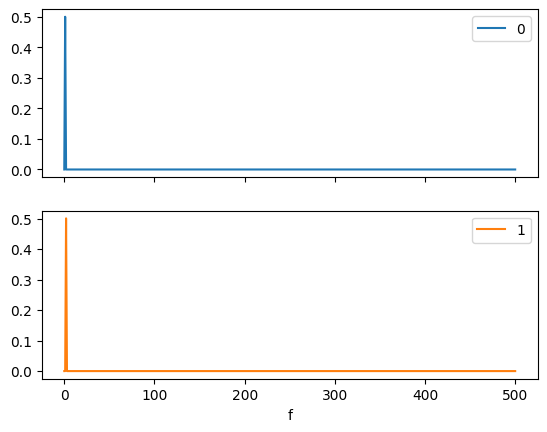

In [5]:
# --- compute_power_spectra()

from scipy import fft
import pytest

def compute_power_spectra(data: np.ndarray,
                          T: float,
                         ) -> (np.ndarray, np.ndarray):
    """
    Compute power spectrum of signals contained in `data`.
    
    Arguments
    ---------
    * data: 2D array containing signal data. Each column contains the time series for
      a single signal

    * T: length of time covered by data

    Return values
    -------------
    * power_spectra: 2D array containing power spectra of signals
    
    * frequencies: 1D array containing frequencies
    """
    # Compute DFT
    #
    # Note: we use norm = forward to correctly scale the DFT for power spectra calculations
    N = data.shape[0]
    dft = fft.fft(data, axis=0, norm="forward")
    
    # Compute frequencies
    frequencies = fft.fftfreq(N, T/N)

    # Remove redundant frequencies
    f_idx_max = int(np.ceil(N/2))
    frequencies = frequencies[0:f_idx_max+1]
    if N % 2 == 0:
        frequencies[-1] *= -1

    # Compute power spectra
    power_spectra = 1 / T * np.abs(dft[0:f_idx_max+1])**2
    
    # Account for contributions from negative frequencies
    if N % 2 == 0:
        power_spectra[1:-1] *= 2
    else:
        power_spectra[1:] *= 2

    return power_spectra, frequencies

# --- Tests

T = 1
N = 1000
t = np.linspace(0, T, num=N)
data = np.empty([N, 2])

f = 1
data[:,0] = np.sin(2 * pi * f * t)

f = 2
data[:,1] = np.cos(2 * pi * f * t)

power_spectra, frequencies = compute_power_spectra(data, T)

# Plot power spectra
plot_df = pd.DataFrame(power_spectra)
plot_df["f"] = frequencies
plot_df.set_index("f", inplace=True)
plot_df.plot(subplots=True, xlabel="f")

plt.show()
display()  # suppress matplotlib console output

# Check that power spectra has non-negligible values only at expected frequencies
locations = np.where(power_spectra > .1 / T)
for i in range(len(locations[0])):
    f = frequencies[locations[0][i]]
    p = power_spectra[locations[0][i], locations[1][i]]
    assert f in [1, 2]
    assert p == pytest.approx(0.5, rel=5e-3)

    # Set value of power_spectra at location to 0 to facilitate checking that
    # power at all other frequencies are negligible.
    power_spectra[locations[0][i], locations[1][i]] = 0
    
assert np.max(np.abs(power_spectra)) < 1e-5

### Load Audio Clips

#### Multi-Source Audio Clips

In [6]:
# --- Load multi-source audio clips

audio_clips = {}
for path in glob.glob(os.path.join(data_dir, "*.wav")):
    # Read audio file
    audio = AudioSegment.from_wav(path)

    # Convert audio to DataFrame
    samples = audio.split_to_mono()[0].get_array_of_samples()
    audio_clips[os.path.basename(path)] = {
        "frame_rate": audio.frame_rate,
        "data": np.array(samples).T.astype(np.float32),
    }
    
# --- Validate data

# Check that frame rate is the same for all clips
frame_rate = None
for clip in audio_clips.values():
    if frame_rate is None:
        frame_rate = clip["frame_rate"]
    assert clip["frame_rate"] == frame_rate

In [7]:
# --- Convert raw audio clips to a DataFrame

audio_data = pd.DataFrame()
for key, clip in audio_clips.items():
    audio_data[key] = clip["data"]

<Figure size 640x480 with 0 Axes>

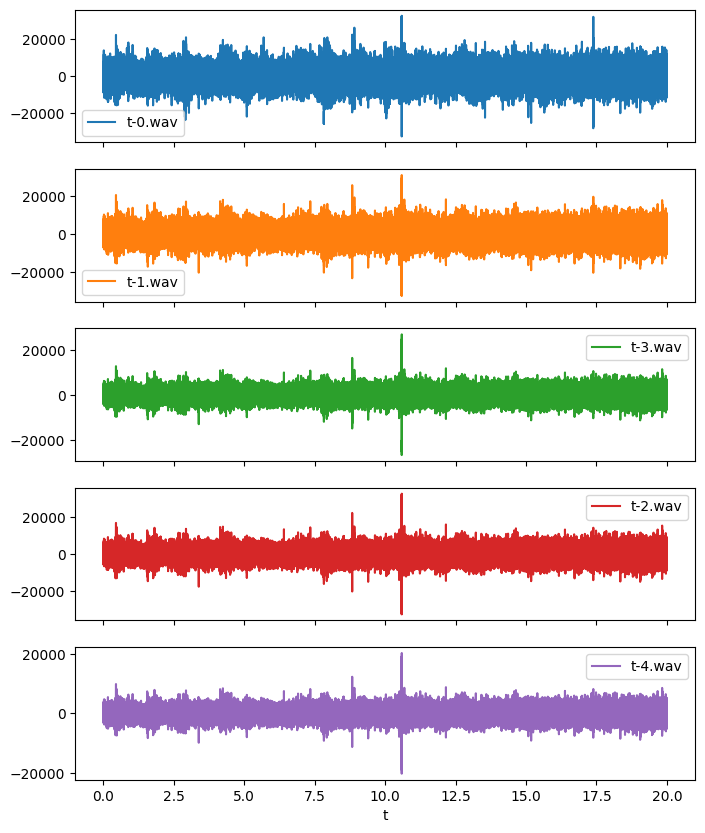

In [8]:
# --- Visually inspect audio clips

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
t_plot_end_idx = frame_rate * t_plot_end
for i in range(audio_data.shape[1]):
    plot_df[f"{audio_data.columns[i]}"] = audio_data.iloc[0:t_plot_end_idx, i]

plot_df["t"] = np.arange(t_plot_end_idx) / frame_rate
plot_df.set_index("t", inplace=True)

# Generate plots
plt.figure()
num_plots = len(audio_data.columns)
t_plot_end_idx = frame_rate * t_plot_end
plot_df.plot(subplots=True,
             figsize=(8, 2*num_plots), 
             layout=(num_plots, 1),
             xlabel="t")

plt.show()
display()  # suppress matplotlib console output

#### Single-Source Audio Clips

In [9]:
# --- Load audio clips for sources

# Get list of source files
with open(os.path.join(data_dir, "sources.yaml")) as file_:
    source_files = yaml.safe_load(file_)
    
pure_source_clips = {}
for file_name in source_files:
    # Construct path to source audio file
    path = os.path.join(sources_dir, file_name)
    
    # Read audio file
    audio = AudioSegment.from_wav(path)

    # Convert audio to DataFrame
    samples = audio.split_to_mono()[0].get_array_of_samples()
    pure_source_clips[file_name] = {
        "frame_rate": audio.frame_rate,
        "num_samples": len(samples),
        "data": np.array(samples).T.astype(np.float32),
    }
    
# --- Validate data

# Check that frame rate for source slips is the same as for mixed audio clips
for clip in pure_source_clips.values():
    assert clip["frame_rate"] == frame_rate

In [10]:
# --- Convert raw audio clips to a DataFrame

pure_source_data = pd.DataFrame()
num_samples = min(clip["num_samples"] for clip in pure_source_clips.values())
for key, clip in pure_source_clips.items():
    pure_source_data[key] = clip["data"][0:num_samples]

<Figure size 640x480 with 0 Axes>

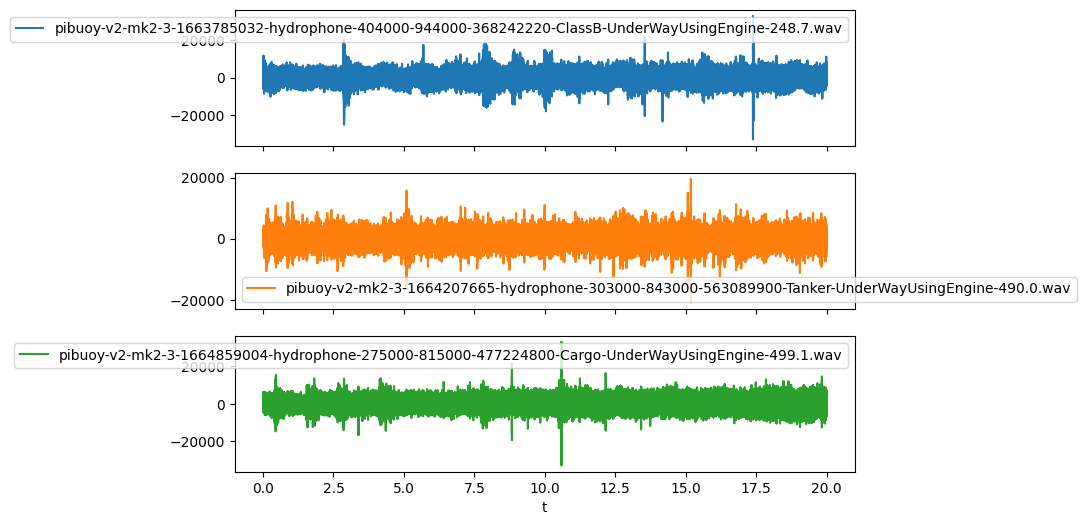

In [11]:
# --- Visually inspect pure source clips

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
t_plot_end_idx = frame_rate * t_plot_end
for i in range(pure_source_data.shape[1]):
    plot_df[f"{pure_source_data.columns[i]}"] = pure_source_data.iloc[0:t_plot_end_idx, i]

plot_df["t"] = np.arange(t_plot_end_idx) / frame_rate
plot_df.set_index("t", inplace=True)

# Generate plots
plt.figure()
num_sources = len(pure_source_clips)
t_plot_end_idx = frame_rate * t_plot_end
plot_df.plot(subplots=True, figsize=(8, 6),
             layout=(num_sources, 1),
             xlabel="t")

plt.show()
display()  # suppress matplotlib console output

<Figure size 640x480 with 0 Axes>

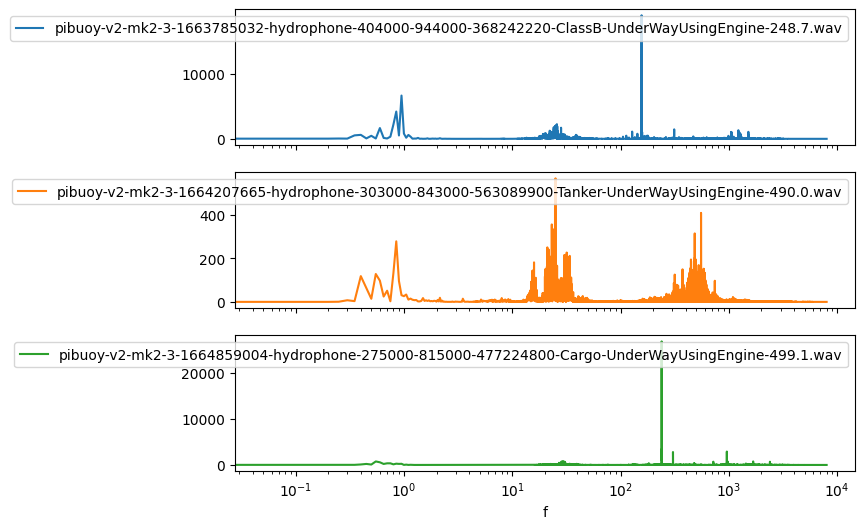

In [12]:
# --- Visually inspect power spectra of pure sources

# Compute power spectra
end_idx = duration * frame_rate
power_spectra_pure_sources, frequencies = compute_power_spectra(pure_source_data.iloc[0:end_idx,:],
                                                                duration)
# Construct DataFrame for plotting
plot_df = pd.DataFrame()
for i in range(pure_source_data.shape[1]):
    plot_df[f"{pure_source_data.columns[i]}"] = power_spectra_pure_sources[:, i]

plot_df["f"] = frequencies
plot_df.set_index("f", inplace=True)

# Generate plots
plt.figure()
num_sources = len(pure_source_data.columns)
plot_df.plot(subplots=True, figsize=(8, 6),
             layout=(num_sources, 1),
             logx=True,
             xlabel="f")

plt.show()
display()  # suppress matplotlib console output

### ICA Without Filtering

#### Perform ICA to Extract Sources from Audio Clips

In [13]:
# --- Perform ICA on audio clips

# Extract data to use for analysis
ica_analysis_end_idx = duration * frame_rate
analysis_data = audio_data.iloc[0:ica_analysis_end_idx, :].to_numpy()

# Perform ICA
sources_ica, source_means, mixing_matrix = perform_ica(analysis_data,
                                                       num_sources=num_active_sources)

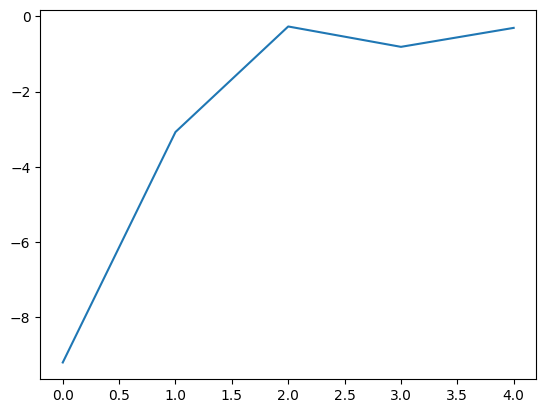

In [14]:
# --- Visually inspect mean

plt.figure()
plt.plot(source_means)

<Figure size 640x480 with 0 Axes>

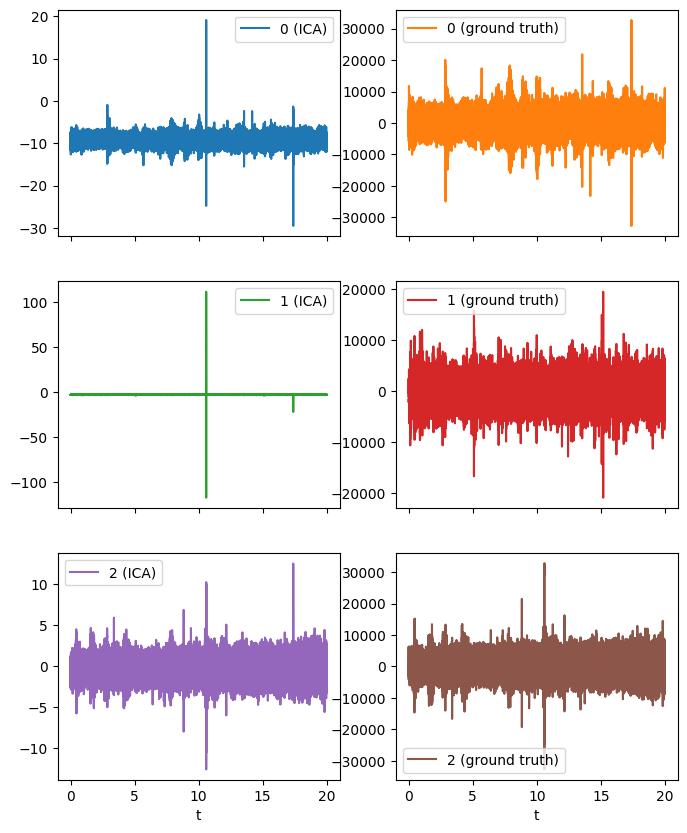

In [15]:
# --- Compare extracted source signals to pure source signals

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
t_plot_end_idx = frame_rate * t_plot_end
for i in range(sources_ica.shape[1]):
    plot_df[f"{i} (ICA)"] = sources_ica[0:t_plot_end_idx, i] + source_means[i]
    if i < pure_source_data.shape[1]:
        plot_df[f"{i} (ground truth)"] = pure_source_data.iloc[0:t_plot_end_idx, i]

plot_df["t"] = np.arange(len(plot_df)) / frame_rate
plot_df.set_index("t", inplace=True)
        
# Generate plots
plt.figure()
plot_df.plot(subplots=True, figsize=(8, 10),
             layout=(sources_ica.shape[1], 2),
             xlabel="t"
            )

plt.show()
display()  # suppress matplotlib console output

<Figure size 640x480 with 0 Axes>

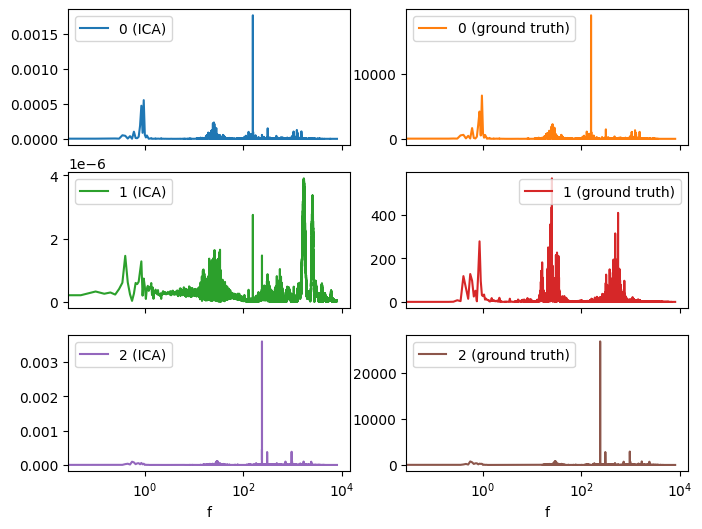

In [16]:
# --- Compare power spectra for extracted and pure source signals

# Compute power spectra
ica_analysis_end_idx = duration * frame_rate
power_spectra_ica, frequencies = compute_power_spectra(sources_ica, duration)
power_spectra_pure_sources, frequencies = compute_power_spectra(pure_source_data.iloc[0:ica_analysis_end_idx,:],
                                                                duration)

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
t_plot_end_idx = frame_rate * t_plot_end
for i in range(power_spectra_ica.shape[1]):
    plot_df[f"{i} (ICA)"] = power_spectra_ica[:, i]
    if i < power_spectra_pure_sources.shape[1]:
        plot_df[f"{i} (ground truth)"] = power_spectra_pure_sources[:, i]

plot_df["f"] = frequencies
plot_df.set_index("f", inplace=True)

# Generate plots
fig = plt.figure()
num_plots = power_spectra_ica.shape[1]
plot_df.plot(subplots=True, figsize=(8, 2*num_plots),
             layout=(num_plots, 2),
             logx=True,
             xlabel="f",
            )

plt.show()
display()  # suppress matplotlib console output

<Figure size 640x480 with 0 Axes>

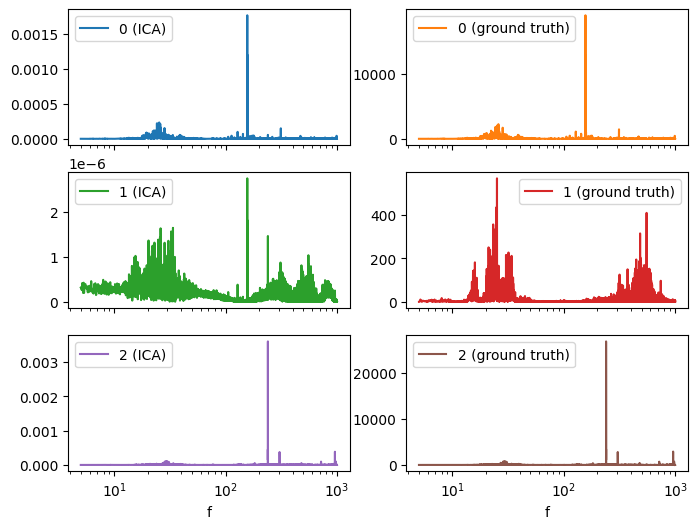

In [17]:
# --- Compare power spectra for extracted and pure source signals in pass band

# Compute power spectra
ica_analysis_end_idx = duration * frame_rate
power_spectra_ica, frequencies = compute_power_spectra(sources_ica, duration)
power_spectra_pure_sources, frequencies = compute_power_spectra(pure_source_data.iloc[0:ica_analysis_end_idx,:],
                                                                duration)

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
t_plot_end_idx = frame_rate * t_plot_end
for i in range(power_spectra_ica.shape[1]):
    plot_df[f"{i} (ICA)"] = power_spectra_ica[:, i]
    if i < power_spectra_pure_sources.shape[1]:
        plot_df[f"{i} (ground truth)"] = power_spectra_pure_sources[:, i]

plot_df["f"] = frequencies
plot_df.set_index("f", inplace=True)

# Restrict frequency domain to frequencies in the pass band
f = frequencies[frequencies >= min(passband)]
start_idx = np.where(frequencies == f[0])[0][0]
f = f[f <= max(passband)]
end_idx = len(f) + start_idx
plot_df = plot_df.iloc[start_idx:end_idx,:]

# Generate plots
fig = plt.figure()
num_plots = power_spectra_ica.shape[1]
plot_df.plot(subplots=True, figsize=(8, 2*num_plots),
             layout=(num_plots, 2),
             logx=True,
             xlabel="f",
            )

plt.show()
display()  # suppress matplotlib console output

### ICA With Filtering

#### Preprocess Data

In [18]:
# --- Apply filtering to remove frequencies that are not likely to originate from
#     the sources.

# Construct Butterworth filter
N, Wn = signal.buttord(passband, stopband, gpass, gstop, fs=frame_rate)
sos = signal.butter(N, Wn, btype='bandpass', output='sos', fs=frame_rate)

# Filter multi-source clips
audio_data_filtered = np.empty(audio_data.shape)
for i in range(audio_data.shape[1]):
    audio_data_filtered[:,i] = signal.sosfilt(sos, audio_data.iloc[:,i])
    
# Filter pure-source clips
pure_source_data_filtered = np.empty(pure_source_data.shape)
for i in range(len(pure_source_clips)):
    pure_source_data_filtered[:,i] = signal.sosfilt(sos, pure_source_data.iloc[:,i])

<Figure size 640x480 with 0 Axes>

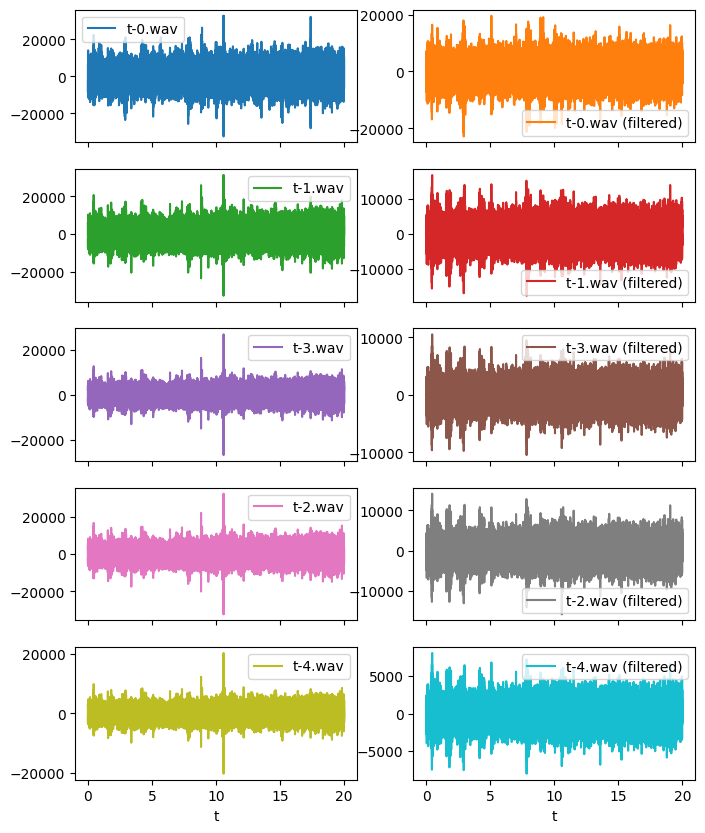

In [19]:
# --- Visually inspect filtered clips

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
t_plot_end_idx = frame_rate * t_plot_end
for i in range(audio_data_filtered.shape[1]):
    plot_df[f"{audio_data.columns[i]}"] = audio_data.iloc[0:t_plot_end_idx, i]
    plot_df[f"{audio_data.columns[i]} (filtered)"] = audio_data_filtered[0:t_plot_end_idx, i]

plot_df["t"] = np.arange(t_plot_end_idx) / frame_rate
plot_df.set_index("t", inplace=True)

# Generate plots
plt.figure()
plot_df.plot(subplots=True, figsize=(8, 10),
             layout=(len(audio_data.columns), 2),
             xlabel="t"
            )

plt.show()
display()  # suppress matplotlib console output

#### Perform ICA to Extract Sources from Audio Clips

In [20]:
# --- Perform ICA on audio clips

# Extract data to use for analysis
ica_analysis_end_idx = duration * frame_rate
analysis_data_filtered = audio_data_filtered[0:ica_analysis_end_idx, :]

# Perform ICA
(sources_ica_filtered, source_means_filtered,
 mixing_matrix_filtered) = perform_ica(analysis_data_filtered,
                                       num_sources=num_active_sources)

<Figure size 640x480 with 0 Axes>

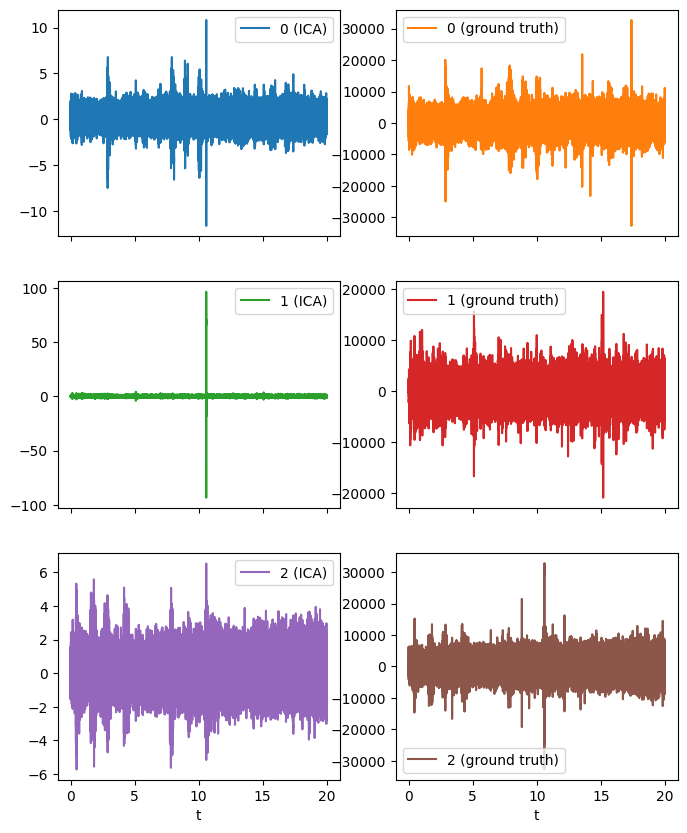

In [21]:
# --- Compare extracted source signals to pure source signals

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
t_plot_end_idx = frame_rate * t_plot_end
for i in range(sources_ica_filtered.shape[1]):
    plot_df[f"{i} (ICA)"] = sources_ica_filtered[0:t_plot_end_idx, i] + source_means_filtered[i]
    if i < pure_source_data.shape[1]:
        plot_df[f"{i} (ground truth)"] = pure_source_data.iloc[0:t_plot_end_idx, i]


plot_df["t"] = np.arange(len(plot_df)) / frame_rate
plot_df.set_index("t", inplace=True)

# Generate plots
plt.figure()
t_plot_end_idx = frame_rate * t_plot_end
plot_df.plot(subplots=True, figsize=(8, 10),
             layout=(sources_ica_filtered.shape[1], 2),
             xlabel="t"
            )    

plt.show()
display()  # suppress matplotlib console output

<Figure size 640x480 with 0 Axes>

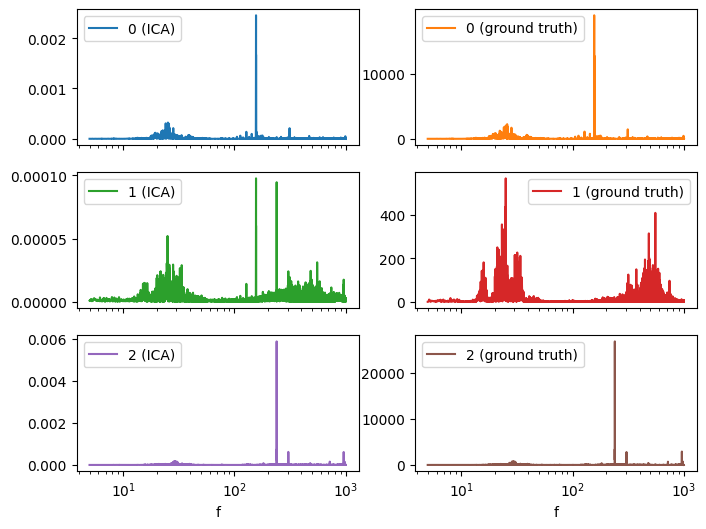

In [22]:
# --- Compare power spectra for extracted and pure source signals

# Compute power spectra
ica_analysis_end_idx = duration * frame_rate
power_spectra_ica, frequencies = compute_power_spectra(sources_ica_filtered, duration)
power_spectra_pure_sources, frequencies = compute_power_spectra(pure_source_data.iloc[0:ica_analysis_end_idx,:],
                                                                duration)

# Construct DataFrame for plotting
plot_df = pd.DataFrame()
t_plot_end_idx = frame_rate * t_plot_end
for i in range(power_spectra_ica.shape[1]):
    plot_df[f"{i} (ICA)"] = power_spectra_ica[:, i]
    if i < power_spectra_pure_sources.shape[1]:
        plot_df[f"{i} (ground truth)"] = power_spectra_pure_sources[:, i]

plot_df["f"] = frequencies
plot_df.set_index("f", inplace=True)

# Restrict frequency domain to frequencies in the pass band
f = frequencies[frequencies >= min(passband)]
start_idx = np.where(frequencies == f[0])[0][0]
f = f[f <= max(passband)]
end_idx = len(f) + start_idx
plot_df = plot_df.iloc[start_idx:end_idx,:]

# Generate plots
fig = plt.figure()
num_plots = power_spectra_ica.shape[1]
plot_df.plot(subplots=True, figsize=(8, 2*num_plots),
             layout=(num_plots, 2),
             logx=True,
             xlabel="f",
            )

plt.show()
display()  # suppress matplotlib console output